In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from glob import glob
from os import path

In [2]:
def cleanup_df(df: pd.DataFrame) -> pd.DataFrame:
    df.drop(columns=["Unnamed: 0"], inplace=True)
    cols_to_keep = [
        'label', 
        'version', 
        'fold', 
        'metrics_val_dsc_0_epoch_final', 
        'metrics_val_dsc_1_epoch_final',
        'metrics_val_dsc_2_epoch_final',
    ]
    
    return df[cols_to_keep]

In [3]:
df_transfer = cleanup_df(pd.read_csv(path.join("..", "from_arc", "knee_parsed.csv")))
df_solo = cleanup_df(pd.read_csv(path.join("..", "from_arc", "knee_base_parsed.csv")))

Process the solo dataframe to first get the average across folds, then to select the best version of each model architecture based on which one segments the cortical bone the best (`dsc_0`)

In [4]:
df_solo = df_solo.groupby(["label", "version"]).mean().drop(columns=['fold'])
df_solo = df_solo.sort_values(by=['label', 'metrics_val_dsc_0_epoch_final'], ascending=False).reset_index()
idxs = df_solo.groupby(["label"])['metrics_val_dsc_0_epoch_final'].transform(max) == df_solo['metrics_val_dsc_0_epoch_final']
df_solo = df_solo[idxs]
df_solo

,label,version,metrics_val_dsc_0_epoch_final,metrics_val_dsc_1_epoch_final,metrics_val_dsc_2_epoch_final
0,unetr_3d_knee_base_cv,17488469,0.873228,0.953516,0.971761
6,unetpp_3d_knee_base_cv,17488464,0.865332,0.953793,0.980080
18,unet_3d_knee_base_cv,17488451,0.823453,0.922949,0.970816
36,segresnetvae_3d_knee_base_cv,17488434,0.748274,0.910794,0.937864
42,segan_3d_knee_base_cv,17488429,0.884788,0.956946,0.979996


Process the results from doing transfer learning next

In [5]:
# group by the label and version and get the mean validation cortical dice
df_transfer = df_transfer.groupby(['label', 'version']).mean().drop(columns=['fold']).sort_values(by='metrics_val_dsc_0_epoch_final', ascending=False).reset_index()
df_transfer

,label,version,metrics_val_dsc_0_epoch_final,metrics_val_dsc_1_epoch_final,metrics_val_dsc_2_epoch_final
0,unetr_3d_knee_cv,17172956,0.939819,0.981858,0.986258
1,unetpp_3d_knee_cv,17172953,0.930721,0.976405,0.988502
2,segresnetvae_3d_knee_cv,17172959,0.902515,0.969833,0.981878
3,unet_3d_knee_cv,17172952,0.889444,0.956913,0.984546
4,segan_3d_knee_cv,17172958,0.856801,0.930432,0.970391


Now combine the two dataframes together. First we want to rename some columns so that we know where data came from:

In [6]:
solo_renaming = {}
for col in df_solo.columns:
    if col != "label":
        solo_renaming[col] = col.replace("metrics_val_", "").replace("_epoch_final", "")
transfer_renaming = {}
for col in df_transfer.columns:
    if col != "label":
        transfer_renaming[col] = col.replace("metrics_val_", "").replace("_epoch_final", "")

df_solo.rename(columns=solo_renaming, inplace=True)
df_transfer.rename(columns=transfer_renaming, inplace=True)

Rename the labels of each model also, so that they match up:

In [7]:
df_solo["label"] = df_solo["label"].apply(lambda x: x.replace("_knee_base_cv", ""))
df_transfer["label"] = df_transfer["label"].apply(lambda x: x.replace("_knee_cv", ""))

Add a column to each dataframe so we can tell where the data came from.

In [8]:
df_solo["training_method"] = "From-Scratch Learning"
df_transfer["training_method"] = "Transfer Learning"

In [9]:
df_solo

,label,version,dsc_0,dsc_1,dsc_2,training_method
0,unetr_3d,17488469,0.873228,0.953516,0.971761,From-Scratch Learning
6,unetpp_3d,17488464,0.865332,0.953793,0.980080,From-Scratch Learning
18,unet_3d,17488451,0.823453,0.922949,0.970816,From-Scratch Learning
36,segresnetvae_3d,17488434,0.748274,0.910794,0.937864,From-Scratch Learning
42,segan_3d,17488429,0.884788,0.956946,0.979996,From-Scratch Learning


In [10]:
df_transfer

,label,version,dsc_0,dsc_1,dsc_2,training_method
0,unetr_3d,17172956,0.939819,0.981858,0.986258,Transfer Learning
1,unetpp_3d,17172953,0.930721,0.976405,0.988502,Transfer Learning
2,segresnetvae_3d,17172959,0.902515,0.969833,0.981878,Transfer Learning
3,unet_3d,17172952,0.889444,0.956913,0.984546,Transfer Learning
4,segan_3d,17172958,0.856801,0.930432,0.970391,Transfer Learning


In [11]:
df = pd.merge(df_solo, df_transfer, how="outer")
df

,label,version,dsc_0,dsc_1,dsc_2,training_method
0,unetr_3d,17488469,0.873228,0.953516,0.971761,From-Scratch Learning
1,unetpp_3d,17488464,0.865332,0.953793,0.980080,From-Scratch Learning
2,unet_3d,17488451,0.823453,0.922949,0.970816,From-Scratch Learning
3,segresnetvae_3d,17488434,0.748274,0.910794,0.937864,From-Scratch Learning
4,segan_3d,17488429,0.884788,0.956946,0.979996,From-Scratch Learning
5,unetr_3d,17172956,0.939819,0.981858,0.986258,Transfer Learning
6,unetpp_3d,17172953,0.930721,0.976405,0.988502,Transfer Learning
7,segresnetvae_3d,17172959,0.902515,0.969833,0.981878,Transfer Learning
8,unet_3d,17172952,0.889444,0.956913,0.984546,Transfer Learning
9,segan_3d,17172958,0.856801,0.930432,0.970391,Transfer Learning


Finally, do a replace on the labels column to make the labels more presentable:

In [12]:
labels_renaming = {
    "unet_3d": "UNet",
    "unetpp_3d": "UNet++",
    "unetr_3d": "UNETR",
    "segresnetvae_3d": "SegResNetVAE",
    "segan_3d": "SeGAN"
}
df = df.replace({"label": labels_renaming})
df

,label,version,dsc_0,dsc_1,dsc_2,training_method
0,UNETR,17488469,0.873228,0.953516,0.971761,From-Scratch Learning
1,UNet++,17488464,0.865332,0.953793,0.980080,From-Scratch Learning
2,UNet,17488451,0.823453,0.922949,0.970816,From-Scratch Learning
3,SegResNetVAE,17488434,0.748274,0.910794,0.937864,From-Scratch Learning
4,SeGAN,17488429,0.884788,0.956946,0.979996,From-Scratch Learning
5,UNETR,17172956,0.939819,0.981858,0.986258,Transfer Learning
6,UNet++,17172953,0.930721,0.976405,0.988502,Transfer Learning
7,SegResNetVAE,17172959,0.902515,0.969833,0.981878,Transfer Learning
8,UNet,17172952,0.889444,0.956913,0.984546,Transfer Learning
9,SeGAN,17172958,0.856801,0.930432,0.970391,Transfer Learning


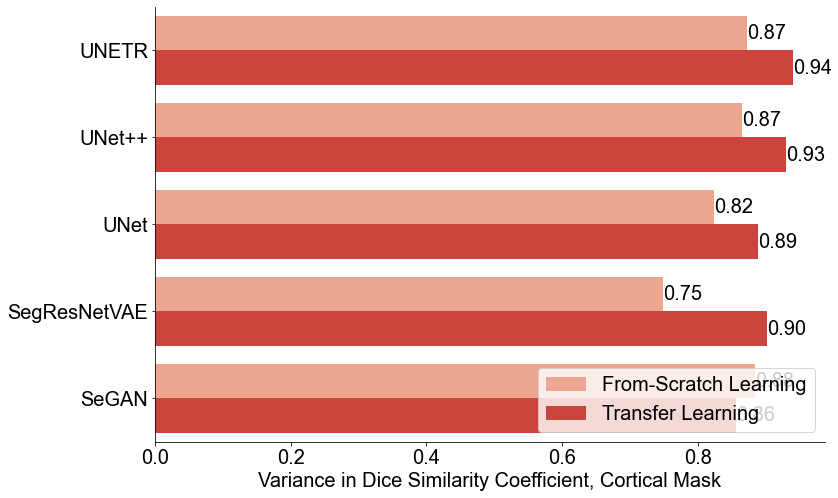

In [13]:
rc = {'figure.figsize':(10,5),
      'axes.facecolor':'white',
      'axes.grid' : True,
      'grid.color': '1',
      'font.family':'Arial',
      'font.size' : 20}
plt.rcParams.update(rc)

plt.rcParams.update(rc)

plt.figure(figsize=(12,8))

ax = sns.barplot(data=df, y="label", x="dsc_0", hue="training_method", palette="Reds")
plt.legend(loc="lower right")

ax.set(
    ylabel="",
    xlabel="Variance in Dice Similarity Coefficient, Cortical Mask"
)

for i in ax.containers:
    ax.bar_label(i, fmt="%0.2f")

plt.grid(axis="x")
sns.despine()

plt.show()

In [14]:
df_transfer[df_transfer["label"]=="unetr_3d"]

,label,version,dsc_0,dsc_1,dsc_2,training_method
0,unetr_3d,17172956,0.939819,0.981858,0.986258,Transfer Learning


Make a figure for the McCaig meeting abstract.

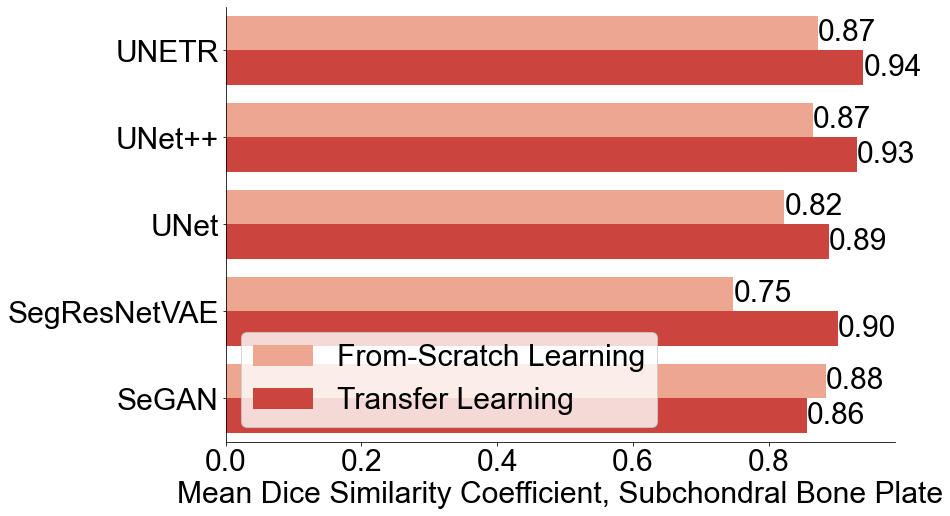

In [21]:
rc = {'figure.figsize':(10,6),
      'axes.facecolor':'white',
      'axes.grid' : True,
      'grid.color': '1',
      'font.family':'Arial',
      'font.size' : 30}
plt.rcParams.update(rc)

plt.rcParams.update(rc)

plt.figure(figsize=(12,8))

ax = sns.barplot(data=df, y="label", x="dsc_0", hue="training_method", palette="Reds")
plt.legend(loc="lower left")

ax.set(
    ylabel="",
    xlabel="Mean Dice Similarity Coefficient, Subchondral Bone Plate"
)

for i in ax.containers:
    ax.bar_label(i, fmt="%0.2f")

plt.grid(axis="x")
sns.despine()

plt.show()